# MODULE 3

IN THIS NB, WE ARE GONNA DEVELOP A ML MODEL TO THE FEATURE FRAME DATASETS

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score, auc
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline


In [2]:
df = pd.read_csv('../../data/feature_frame.csv')

In [3]:
df.dropna().head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [4]:
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [5]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
feature_cols = {col for col in df if col not in info_cols + [label_col]}

categorical_cols = ['product_type', 'vendor']
binary_cols= ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = {col for col in feature_cols if col not in categorical_cols + binary_cols}

In [6]:
df[label_col].value_counts()

outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64

In [9]:
# get those orders with more than 5 products

items_per_order = df.groupby('order_id').outcome.sum()
big_orders = items_per_order[items_per_order > 5].index

df_2 = df[df['order_id'].isin(big_orders)]

In [8]:
test_df = df_2.groupby('order_id').outcome.sum()
test_df.head(10)

order_id
2807985930372     9.0
2808027644036     6.0
2808099078276     9.0
2808393957508    13.0
2808434524292     7.0
2808548917380     7.0
2808549900420     9.0
2808728715396    12.0
2808769085572    15.0
2808786714756    16.0
Name: outcome, dtype: float64

In [10]:
df_2['order_date'] = pd.to_datetime(df_2['order_date'])

/tmp/ipykernel_10185/1778527225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['order_date'] = pd.to_datetime(df_2['order_date'])


In [11]:
daily_orders = df_2.groupby('order_date').order_id.nunique()

daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     5
2020-10-08    10
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

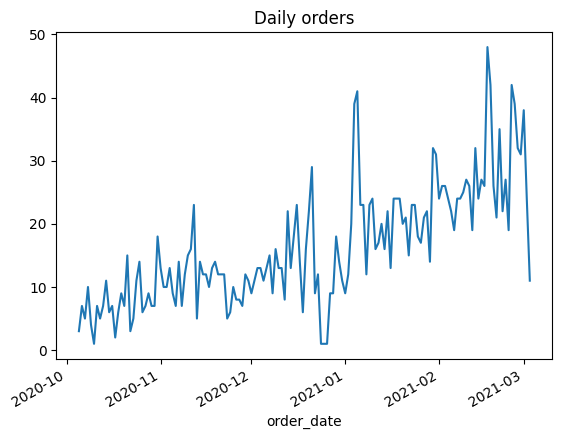

In [12]:
daily_orders.plot()
plt.title('Daily orders')

Must take into account the evolution of the number of orders. Take this into account when doing the train, validation and test split

In [13]:
df_2 = df_2.sort_values(by='order_date')

In [15]:
n_total = len(df_2)
n_train = int(0.6 * n_total)
n_val = int (0.2 * n_total)

train_df = df_2[:n_train]
val_df = df_2[n_train:n_train + n_val]
test_df = df_2[n_train + n_val:]

We've selected 60/20/20 in order to get enough data for each one of the parts. 10% for test couldn't be enough. We only have 5 months of data.

Now we can start thinking on which predictive and target features are we gonna set.

Categorical wont be added by now

In [16]:
predictive_cols = binary_cols + list(numerical_cols)

In [17]:
X_train = train_df[predictive_cols]
y_train = train_df[label_col]

X_val = val_df[predictive_cols]
y_val = val_df[label_col]

X_test = test_df[predictive_cols]
y_test = test_df[label_col]

In [18]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (1213830, 19), y_train shape: (1213830,)
X_val shape: (404610, 19), y_val shape: (404610,)
X_test shape: (404610, 19), y_test shape: (404610,)


In [19]:
# it's not OK because we need to scale with mean and std just of the train data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

## 1. Baseline

In order to get a simple way to predict, we are gonna take global_popularity as the unique predictive col

In [23]:
df[['global_popularity']].head(20)

,global_popularity
0,0.000000
1,0.000000
2,0.000000
3,0.038462
4,0.038462
5,0.038462
6,0.038462
7,0.038462
8,0.038462
9,0.038462


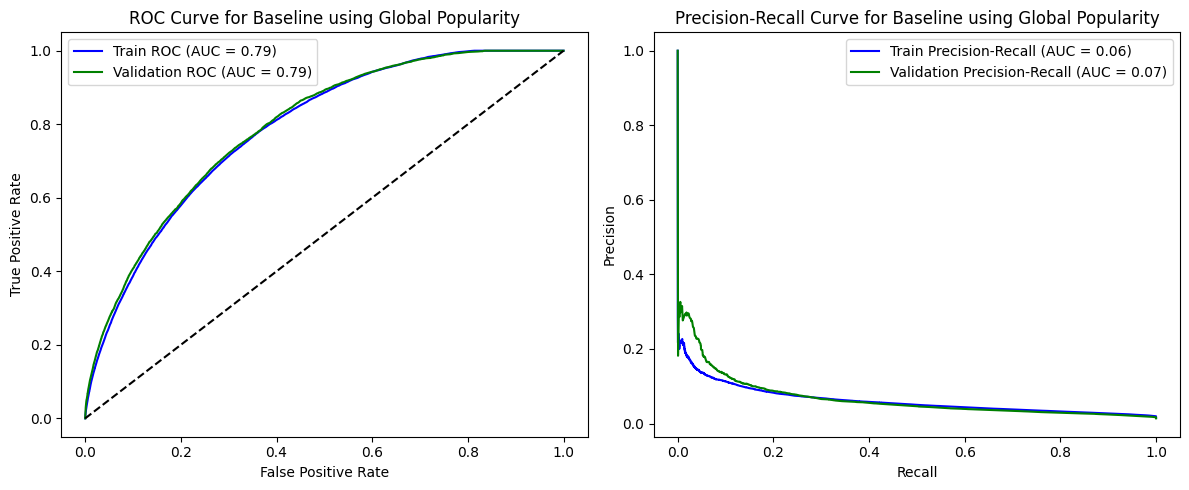

In [29]:
y_train_pred_proba = X_train['global_popularity']
y_val_pred_proba = X_val['global_popularity']

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
auc_train = auc(fpr_train, tpr_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
auc_val = auc(fpr_val, tpr_val)

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
pr_auc_train = average_precision_score(y_train, y_train_pred_proba)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
pr_auc_val = average_precision_score(y_val, y_val_pred_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.2f})', color='blue')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {auc_val:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Baseline using Global Popularity')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(recall_train, precision_train, label=f'Train Precision-Recall (AUC = {pr_auc_train:.2f})', color='blue')
plt.plot(recall_val, precision_val, label=f'Validation Precision-Recall (AUC = {pr_auc_val:.2f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Baseline using Global Popularity')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## 2. Linear regression

First, we are gonna try to develop a linear model by using Ridge regularization with some values (also without it)

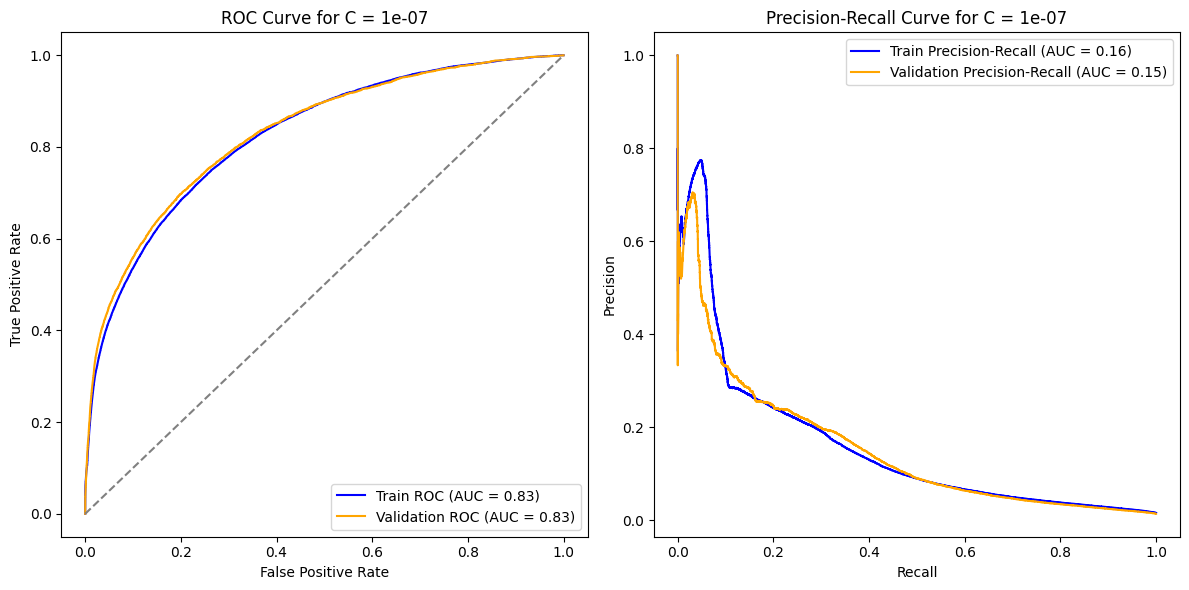

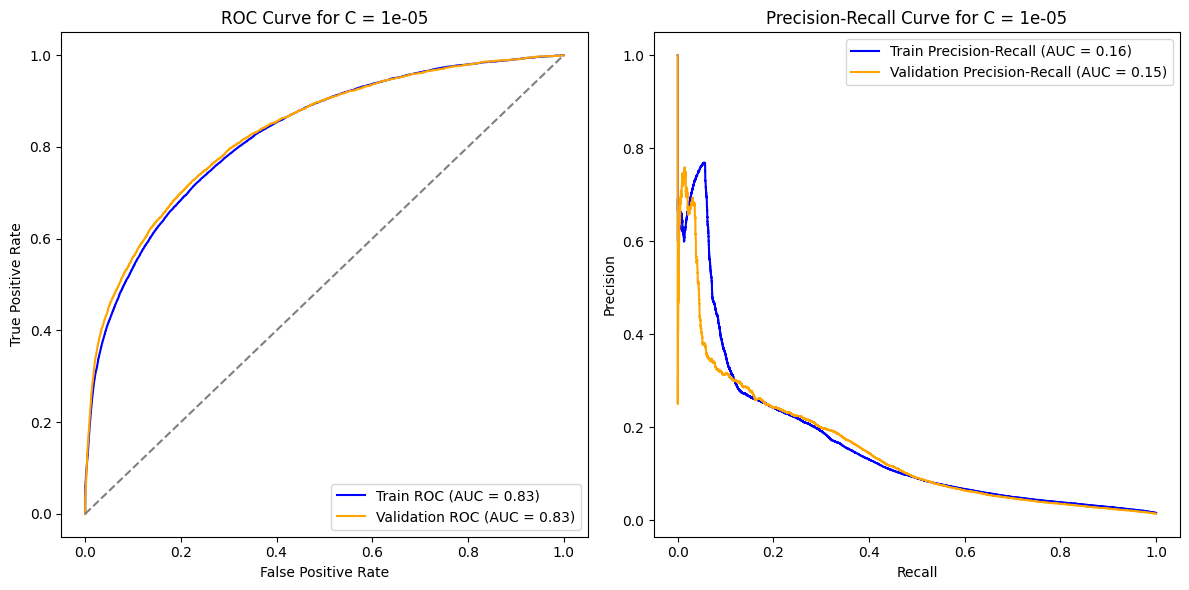

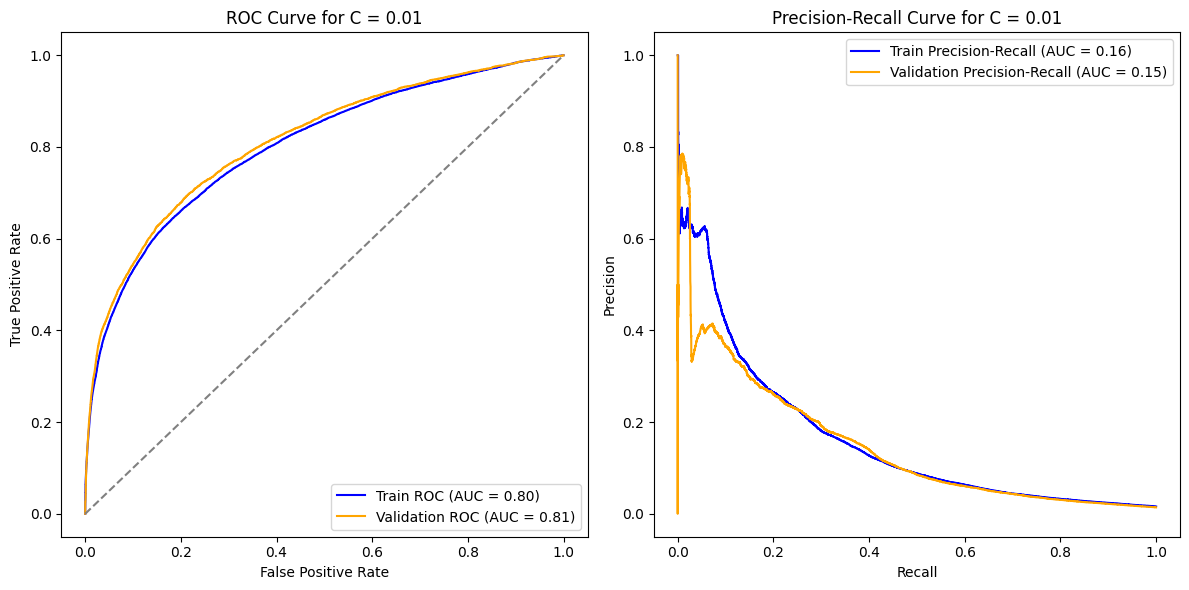

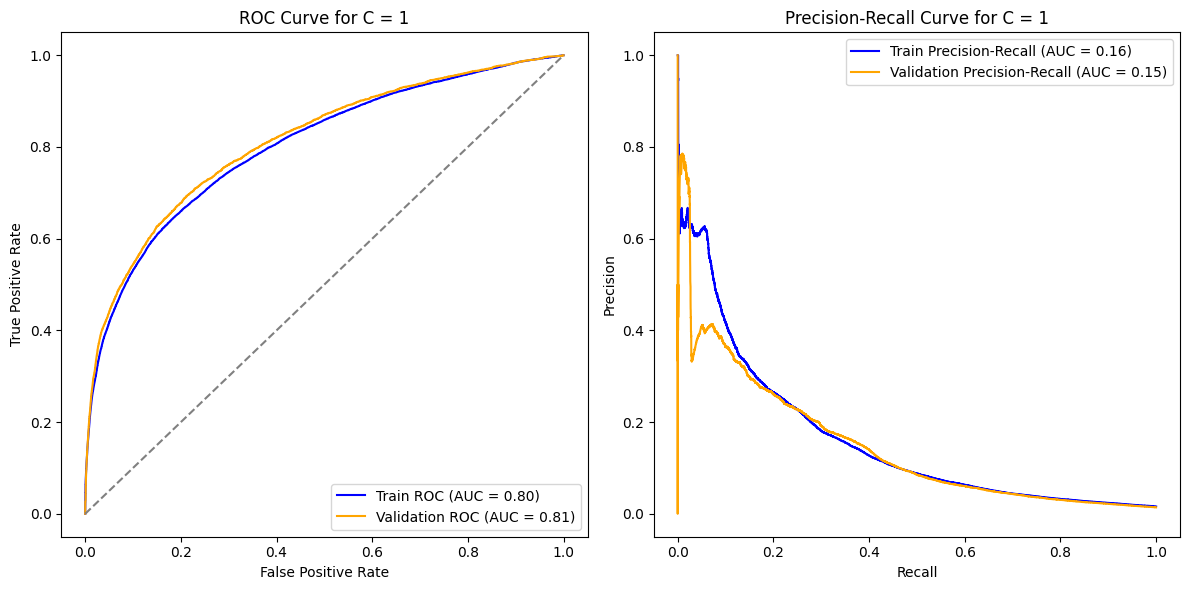

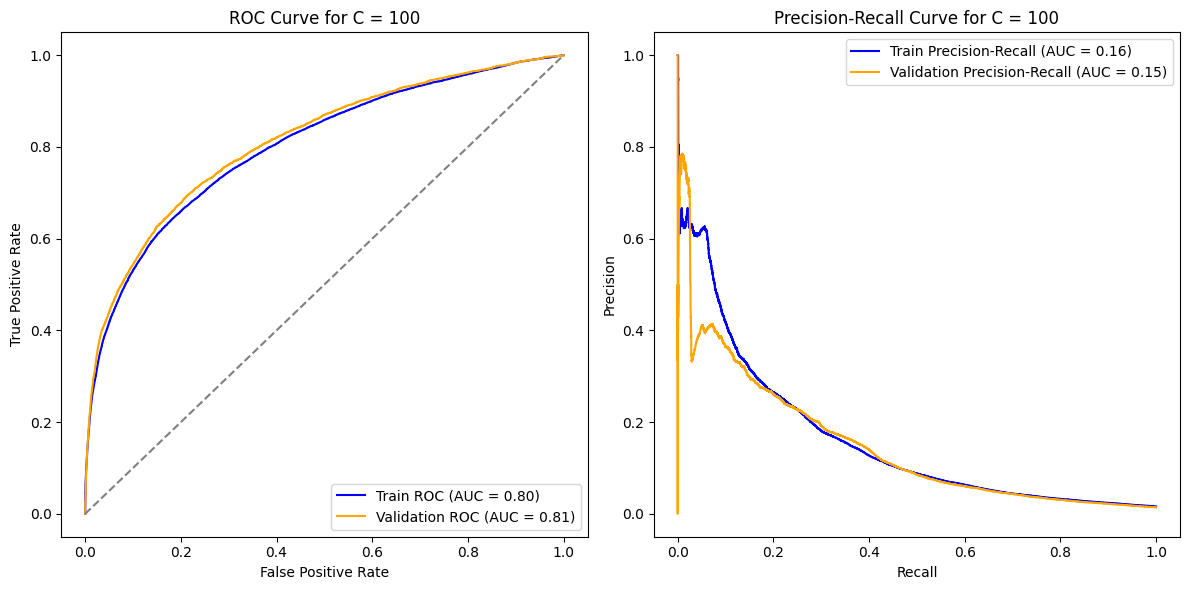

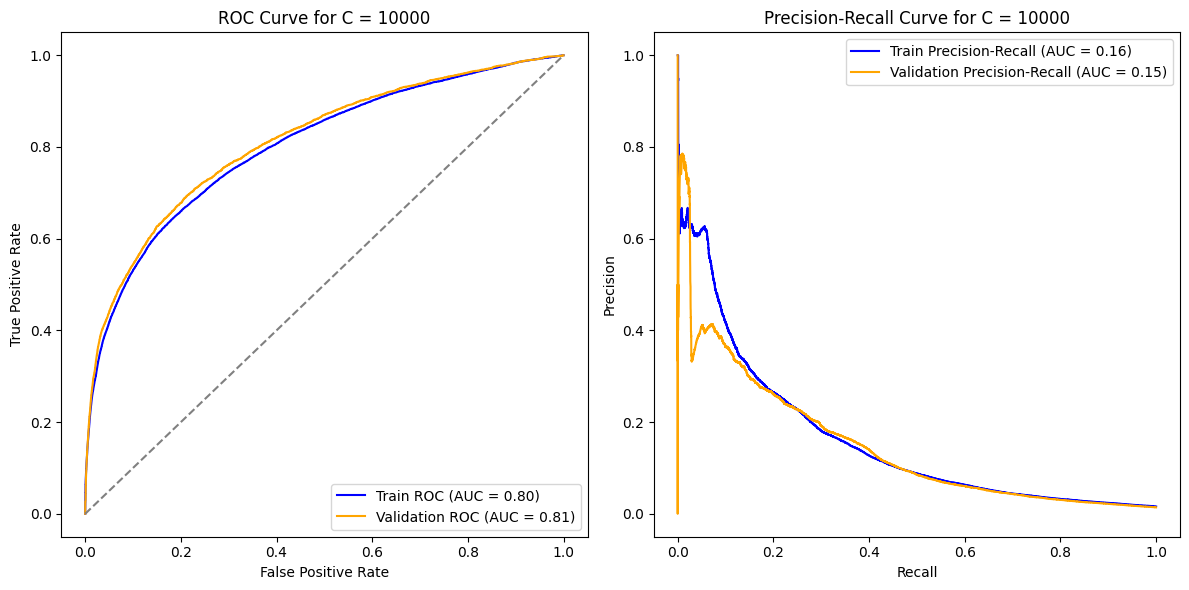

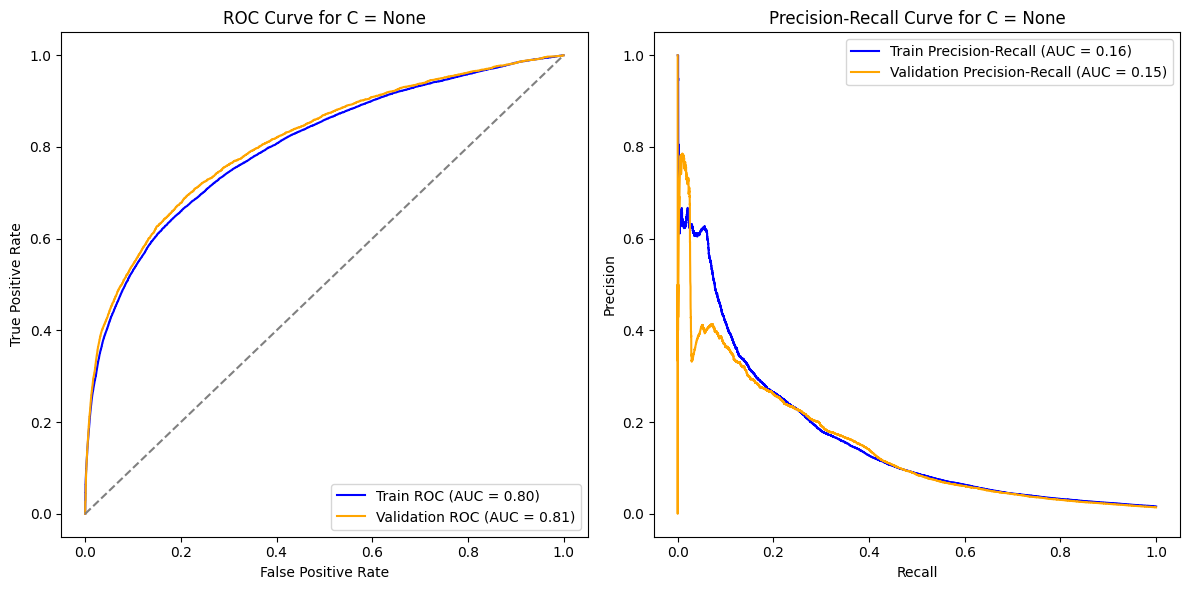

In [ ]:
cs = [0.0000001, 0.00001, 0.01, 1, 100, 10000, None]

for c in cs:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l2' if c else None, C=c if c else 1.0)
    )
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_val_pred = model.predict_proba(X_val)[:, 1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred)
    pr_auc_train = average_precision_score(y_train, y_train_pred)
    pr_auc_val = average_precision_score(y_val, y_val_pred)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_val, tpr_val, color='orange', label=f'Validation ROC (AUC = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for C = {c}')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall_train, precision_train, color='blue', label=f'Train Precision-Recall (AUC = {pr_auc_train:.2f})')
    plt.plot(recall_val, precision_val, color='orange', label=f'Validation Precision-Recall (AUC = {pr_auc_val:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for C = {c}')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


The regularization with Ridge in this case doesn't seem to contribute much, as similar values are obtained when the regularization is null. Let's try Lasso and see if anything changes.

That said, when we applied linear regression, we significantly improved the baseline result.

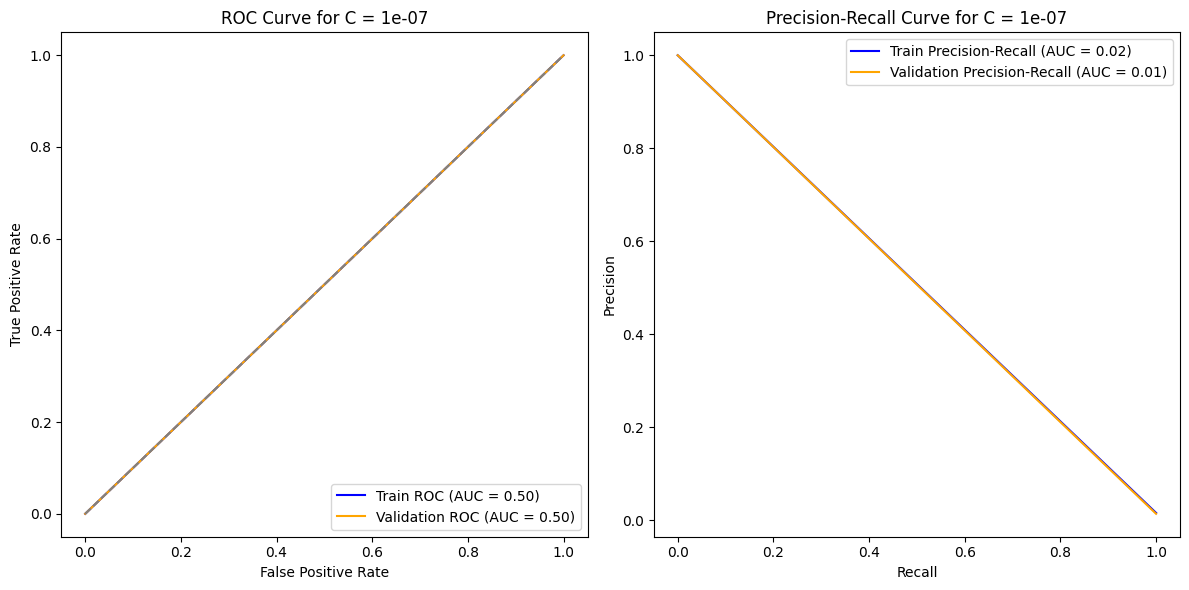

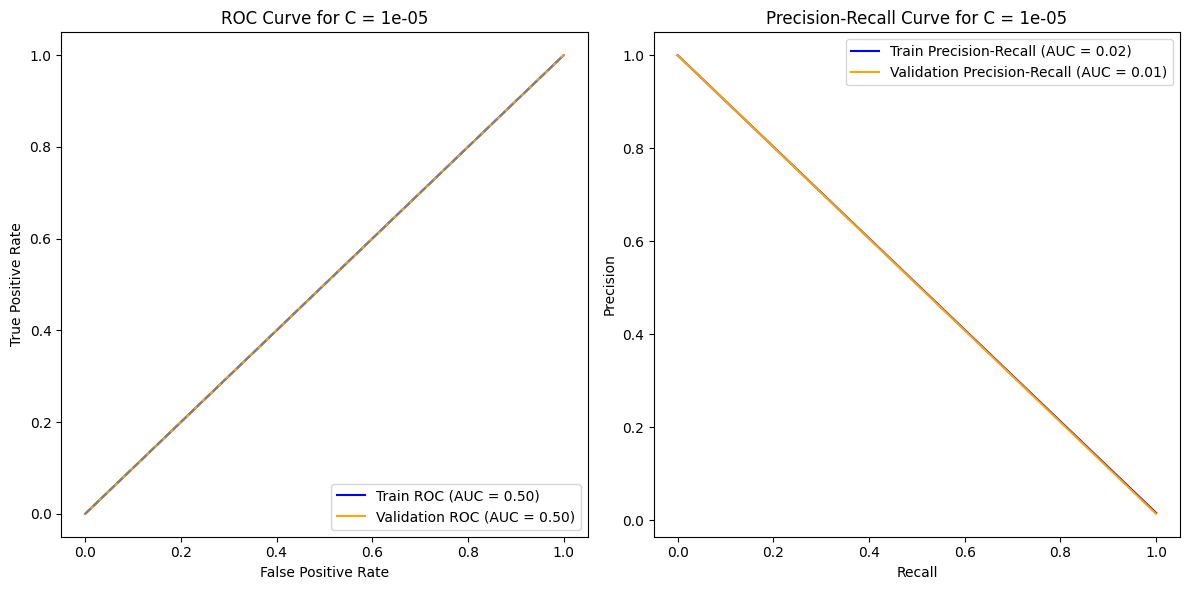

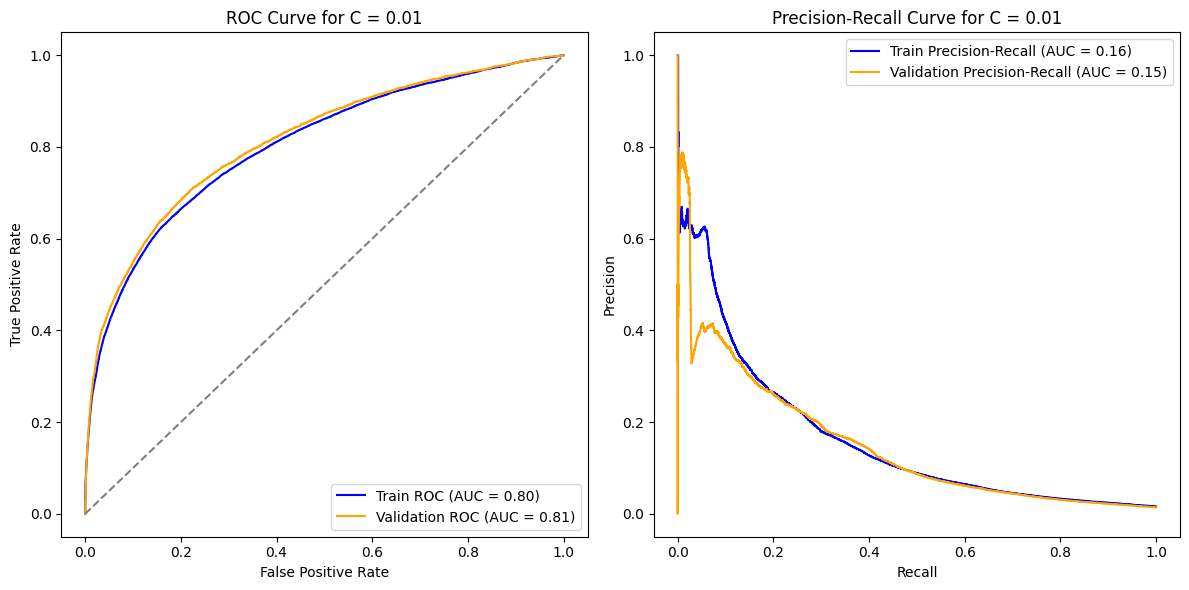

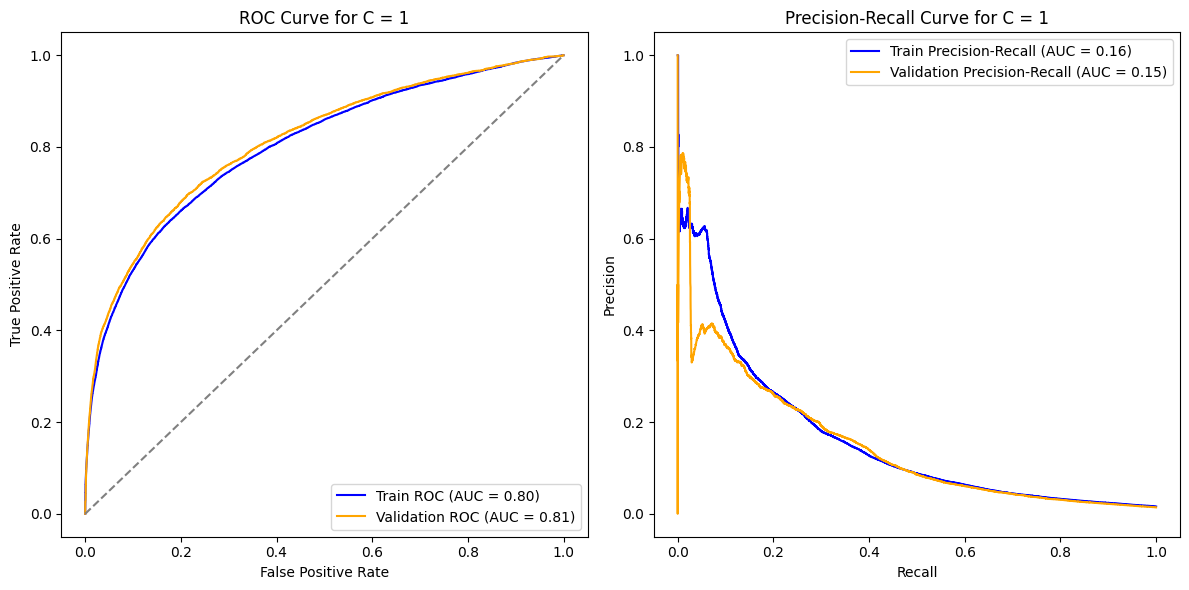

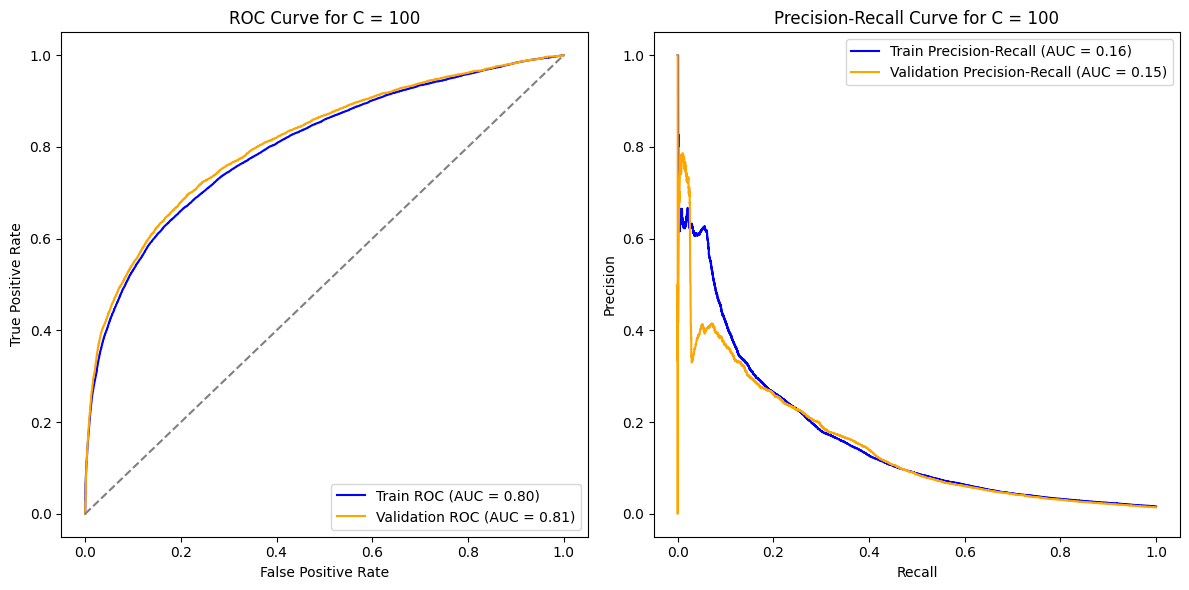

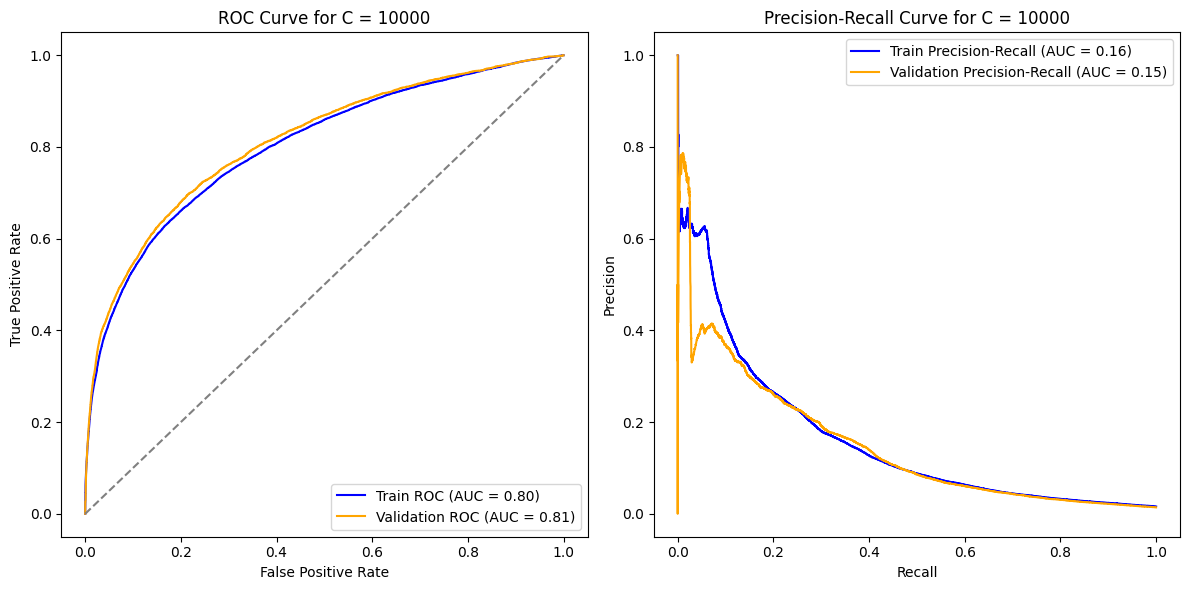

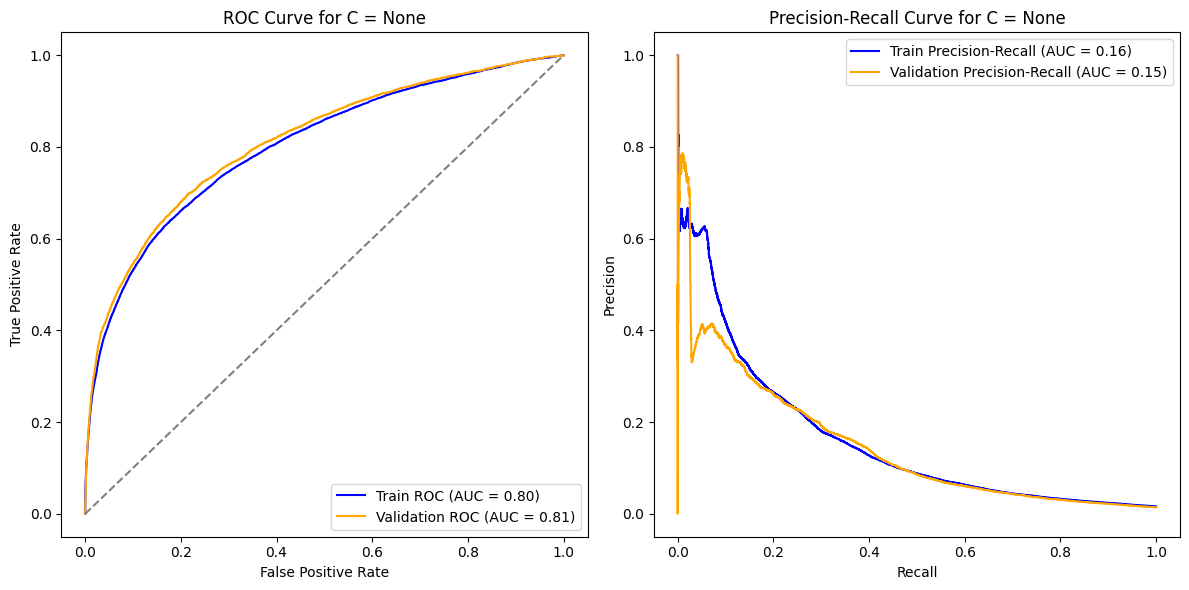

In [37]:
cs = [0.0000001, 0.00001, 0.01, 1, 100, 10000, None]

for c in cs:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l1' if c else None, C=c if c else 1.0, solver='saga')
    )
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_val_pred = model.predict_proba(X_val)[:, 1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred)
    pr_auc_train = average_precision_score(y_train, y_train_pred)
    pr_auc_val = average_precision_score(y_val, y_val_pred)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_val, tpr_val, color='orange', label=f'Validation ROC (AUC = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (aleatoriedad)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for C = {c}')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall_train, precision_train, color='blue', label=f'Train Precision-Recall (AUC = {pr_auc_train:.2f})')
    plt.plot(recall_val, precision_val, color='orange', label=f'Validation Precision-Recall (AUC = {pr_auc_val:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for C = {c}')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

- Very small values in Lasso regularization lead to poor results. 
- Starting from 0.01, the values become similar to Ridge. 
- Additionally, as observed, this regularization doesn't contribute much, and without it, we achieve very similar results. 
- Therefore, it might be a better option to apply linear regression without regularization, as we obtain almost identical results without the need for any additional techniques.
- The dataset is large enough to don't need any regularization

                             Feature  Ridge Coef  Lasso Coef
1                   abandoned_before    0.022370    0.013324
0                     ordered_before    0.020805    0.012507
11                 global_popularity    0.014860    0.006563
3                     set_as_regular    0.003956    0.000000
10                    user_order_seq   -0.001588   -0.000000
8   days_since_purchase_product_type    0.001290    0.000000
13    days_since_purchase_variant_id   -0.001157   -0.000000
6                   normalised_price   -0.000886   -0.000000
5       avg_days_to_buy_product_type   -0.000792   -0.000000
9         std_days_to_buy_variant_id   -0.000789   -0.000000
7         avg_days_to_buy_variant_id   -0.000707   -0.000000
14                        count_pets    0.000468    0.000000
17                      discount_pct    0.000314    0.000000
15                      count_adults    0.000269    0.000000
4       std_days_to_buy_product_type    0.000229   -0.000000
16                    pe

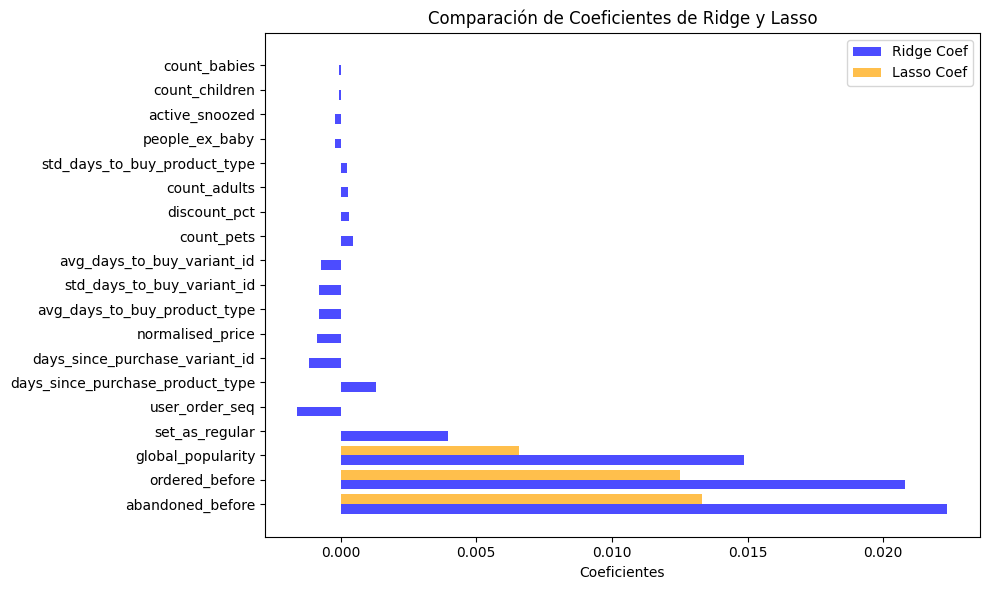

In [44]:
alpha_ridge = 1e-07
alpha_lasso = 0.01

ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha_ridge)) 
lasso = make_pipeline(StandardScaler(), Lasso(alpha=alpha_lasso))

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

ridge_coef = ridge.named_steps['ridge'].coef_
lasso_coef = lasso.named_steps['lasso'].coef_

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ridge Coef': ridge_coef,
    'Lasso Coef': lasso_coef
})

coef_df['Abs Ridge Coef'] = np.abs(coef_df['Ridge Coef'])
coef_df['Abs Lasso Coef'] = np.abs(coef_df['Lasso Coef'])
coef_df = coef_df.sort_values(by=['Abs Ridge Coef', 'Abs Lasso Coef'], ascending=False)

print(coef_df[['Feature', 'Ridge Coef', 'Lasso Coef']])

plt.figure(figsize=(10, 6))

bar_width = 0.4  
index = np.arange(len(coef_df))

plt.barh(index - bar_width/2, coef_df['Ridge Coef'], bar_width, color='blue', alpha=0.7, label='Ridge Coef')

plt.barh(index + bar_width/2, coef_df['Lasso Coef'], bar_width, color='orange', alpha=0.7, label='Lasso Coef')

plt.xlabel('Coeficientes')
plt.title('Comparación de Coeficientes de Ridge y Lasso')
plt.yticks(index, coef_df['Feature'])
plt.legend()

plt.tight_layout()
plt.show()

- Lasso only uses three features, and Ridge uses mainly the same three. We can try to develop a model by using just this three features

In [45]:
top_cols = ['abandoned_before', 'ordered_before', 'global_popularity']

In [47]:
X_train_top = X_train[top_cols]
X_val_top = X_val[top_cols]

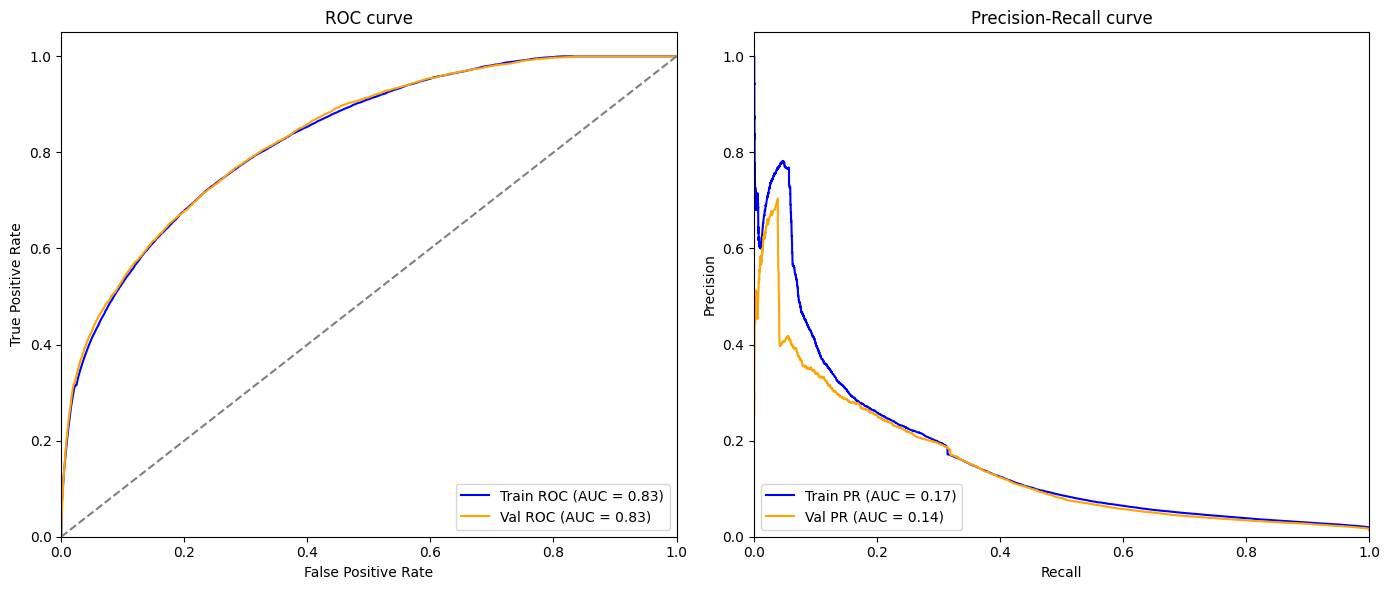

In [48]:
alpha_ridge = 1e-07

ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha_ridge))
ridge.fit(X_train_top, y_train)

y_train_pred = ridge.predict(X_train_top)
y_val_pred = ridge.predict(X_val_top)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
pr_auc_train = auc(recall_train, precision_train)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
roc_auc_val = auc(fpr_val, tpr_val)

precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred)
pr_auc_val = auc(recall_val, precision_val)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(fpr_train, tpr_train, color='blue', label=f'Train ROC (AUC = {roc_auc_train:.2f})')
axes[0].plot(fpr_val, tpr_val, color='orange', label=f'Val ROC (AUC = {roc_auc_val:.2f})')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC curve')
axes[0].legend(loc='lower right')

axes[1].plot(recall_train, precision_train, color='blue', label=f'Train PR (AUC = {pr_auc_train:.2f})')
axes[1].plot(recall_val, precision_val, color='orange', label=f'Val PR (AUC = {pr_auc_val:.2f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall curve')
axes[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

- We find that with less features we get the same results. Because Lasso and Ridge have similar results (but Ridge a little bit better) we set Ridge with 1e-07 regularization as the best option.
- We can also try to include some categorical features